- https://www.kaggle.com/code/nournouur/m-thodes-de-monte-carlo-black-jack-frozenlake
- https://www.kaggle.com/code/positivecoder/rl-frozen-lake-solution-using-value-iteration
- https://www.youtube.com/watch?v=l87rgLg90HI
- https://medium.com/analytics-vidhya/solving-the-frozenlake-environment-from-openai-gym-using-value-iteration-5a078dffe438
- https://zoo.cs.yale.edu/classes/cs470/materials/hws/hw7/FrozenLake.html
- https://mlabonne.github.io/blog/reinforcement%20learning/q-learning/frozen%20lake/gym/tutorial/2022/02/13/Q_learning.html

Q-Learner:
- https://www.kaggle.com/code/sangnguyenai2019/frozen-lake-q-learning-a-parameter-study
- https://medium.com/mlearning-ai/a-deep-dive-into-reinforcement-learning-q-learning-and-deep-q-learning-on-a-10x10-frozenlake-c76d56810a46

In [20]:
!pip install pygame

In [21]:
!pip install gym==0.23.1

  Using cached gym-0.23.1-py3-none-any.whl
  Attempting uninstall: gym
    Found existing installation: gym 0.21.0
    Uninstalling gym-0.21.0:
      Successfully uninstalled gym-0.21.0


In [40]:
import pkg_resources
pkg_resources.require("gym==0.23.1")
import gym
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import pygame
import random
import seaborn as sns
import time

# import os
# os.environ["SDL_VIDEODRIVER"] = "dummy"

VersionConflict: (gym 0.21.0 (c:\users\steve\appdata\local\programs\python\python37\lib\site-packages), Requirement.parse('gym==0.23.1'))

In [41]:
import pkg_resources
import types
def get_imports():
    for name, val in globals().items():
        if isinstance(val, types.ModuleType):
            # Split ensures you get root package, 
            # not just imported function
            name = val.__name__.split(".")[0]

        elif isinstance(val, type):
            name = val.__module__.split(".")[0]

        # Some packages are weird and have different
        # imported names vs. system names
        if name == "PIL":
            name = "Pillow"
        elif name == "sklearn":
            name = "scikit-learn"

        yield name
imports = list(set(get_imports()))

requirements = []
for m in pkg_resources.working_set:
    if m.project_name in imports and m.project_name!="pip":
        requirements.append((m.project_name, m.version))

for r in requirements:
    print("{}=={}".format(*r))

seaborn==0.11.2
pygame==2.1.2
pandas==1.0.5
numpy==1.21.6
matplotlib==3.1.1
gym==0.21.0


In [42]:
np.random.seed(8)

# Helpful Functions

In [43]:
def play_episodes(env, n_episodes, policy, random = False, rewards_aggrated=True):
    """
    This fucntion plays the given number of episodes given by following a policy or sample randomly from action_space.
    
    Parameters:
        enviorment: openAI GYM object
        n_episodes: number of episodes to run
        policy: Policy to follow while playing an episode
        random: Flag for taking random actions. if True no policy would be followed and action will be taken randomly
        
    Return:
        wins: Total number of wins playing n_episodes
        total_reward: Total reward of n_episodes
        avg_reward: Average reward of n_episodes
    
    """
    wins = 0
    total_reward = 0
    rewards = []
    
    
    for episode in range(n_episodes):
        done = False
        run_e_rewards = 0
        # reset the enviorment every time when playing a new episode
        state = env.reset()
        
        while not done:
            if random:
                action = env.action_space.sample()
            else:
                action = policy[state]

            next_state, reward,  done, info = env.step(action)

            total_reward += reward
            run_e_rewards += reward
            state = next_state
            
            if done and reward == 20.0:
                wins += 1
        
        rewards.append(run_e_rewards)
                
    # calculate average reward
    average_reward = total_reward / n_episodes
    
    if rewards_aggrated:
        return wins, total_reward, average_reward
    else:
        return wins, rewards

In [44]:
def value_iteration(env,max_iteration=1000,discount_factor=1):
    threshold=1e-2
    deltas = []
    value_table=np.zeros(env.observation_space.n)
    for i in range(max_iteration):
        prev_table=np.copy(value_table)
        for j in range(env.observation_space.n):
            q_values=[sum([prob*(r+discount_factor*prev_table[s]) for prob,s,r,x in env.P[j][a]]) for a in range(env.action_space.n)]
            value_table[j]=max(q_values)
            
        d = np.sum(np.fabs(prev_table-value_table))
        deltas.append(d)
        if (d <= threshold):
            break
#     print(f"Iterations: {i}")
    return value_table,deltas

In [45]:
def extract_policy(value_table, env, gamma=0.9):
    policy=np.zeros(env.observation_space.n)
    for j in range(env.observation_space.n):
        q_values=[sum([prob*(r+gamma*value_table[s]) for prob,s,r,x in env.P[j][a]]) for a in range(env.action_space.n)]
        policy[j]=np.argmax(np.array(q_values))
    return policy

In [46]:
## Author: Diganta Kalita
## https://github.com/dxganta/solving_openai/blob/master/FrozenLake8x8/frozenLake8x8.py

def get_score(env, policy, episodes=1000):
    misses = 0
    steps_list = []
    truncated=0
    for episode in range(episodes):
        observation = env.reset(seed=8)
        steps=0
        while True:
            action = policy[observation]
            observation, reward, done, info = env.step(action)
            steps+=1
            if info.get('TimeLimit.truncated'):
                truncated += 1
                break
            if done and reward == 1:
                steps_list.append(steps)
                break
            elif done and reward == 0:
                misses += 1
                break
    print('----------------------------------------------')
    print('Number of Episodes ({:.0f}) truncated'.format(truncated))
    print('You took an average of {:.0f} steps to get the frisbee'.format(np.mean(steps_list)))
    print('And you fell in the hole {:.2f} % of the times'.format((misses/(episodes-truncated)) * 100))
    print(f'Loses: {misses}')
    print(f'Wins: {len(steps_list)}')
    print('----------------------------------------------')

## Helper Functions (PI)

In [47]:
def policy_eval(env, policy, V, discount_factor):
    """
    Helper function to evaluate a policy.
    
    Arguments:
        env: openAI GYM Enviorment object.
        policy: policy to evaluate.
        V: Estimated Value for each state. Vector of length nS.
        discount_factor: MDP discount factor.
    Return:
        policy_value: Estimated value of each state following a given policy and state-value 'V'. 
        
    """
    policy_value = np.zeros(env.observation_space.n)
    for state, action in enumerate(policy):
        for probablity, next_state, reward, info in env.P[state][action]:
            policy_value[state] += probablity * (reward + (discount_factor * V[next_state]))
            
    return policy_value

In [48]:
def policy_iteration(env, discount_factor = 0.999, max_iteration = 100, early_stopping=True):
    """
    Algorithm to solve MPD.
    
    Arguments:
        env: openAI GYM Enviorment object.
        discount_factor: MDP discount factor.
        max_iteration: Maximum No.  of iterations to run.
        
    Return:
        V: Optimal state-Value function. Vector of lenth nS.
        new_policy: Optimal policy. Vector of length nS.
    
    """
    V = np.zeros(env.observation_space.n)
    
    # intialize a random policy
    policy = np.random.randint(0, 4, env.observation_space.n)
    prev_policy = np.copy(policy)
    prev_V = np.copy(V)
    deltas = []
    
    for i in range(max_iteration):
        V = policy_eval(env, policy, V, discount_factor)
        policy = extract_policy(V, env, discount_factor)
        
#         d = 1 - np.sum(np.equal(policy, policy_prev))/env.observation_space.n
#         d = np.sum(np.fabs(prev_policy-policy))
        d = np.sum(np.fabs(prev_V-V))
        deltas.append(d)
        
        if np.all(np.isclose(policy, prev_policy)) and early_stopping:
#                 print('policy converged at iteration %d' %(i+1))
            break
        prev_policy = np.copy(policy)
        prev_V = np.copy(V)
            

            
    return V, policy, deltas

## Helpful Function (QL)

In [49]:
def q_learning(env,discount_factor=0.99,train_episodes = 1000,decay=0.01,learning_rate=0.3, early_stopping=False):
    Q = np.zeros((env.observation_space.n, env.action_space.n))
    test_episodes = 100
    max_steps = 100
    epsilon = 1
    max_epsilon = 1
    min_epsilon = 0.01
    env.reset()
    training_rewards = []
    epsilons = []
    training_times=[]
    deltas=[]
    init_time= time.perf_counter()
    for episode in range(train_episodes):
        state = env.reset()
        total_training_rewards = 0
        prev_Q = np.copy(Q)

        for step in range(max_steps):
            random.seed(8)
            if random.uniform(0, 1) > epsilon:
                action = np.argmax(Q[state,:])   #Exploit
            else:
                action = env.action_space.sample() #Explore

            new_state, reward, done, info = env.step(action)

            Q[state, action] = Q[state, action] + learning_rate * (reward + discount_factor * np.max(Q[new_state, :]) - Q[state, action])
            
            total_training_rewards += reward
            state = new_state

            #Ending the episode
            if done:
    #             print ("Total reward for episode {}: {}".format(episode, total_training_rewards))
                break

        epsilon = min_epsilon + (max_epsilon - min_epsilon)*np.exp(-decay*episode)

        training_rewards.append(total_training_rewards)
        epsilons.append(epsilon)
        training_times.append((time.perf_counter()-init_time))
        
        d = np.sum(np.fabs(prev_Q-Q))
        deltas.append(d)
        
        if (np.all(np.isclose(Q, prev_Q))) and early_stopping:
            break
        
        
    return training_rewards,training_times,Q,deltas

In [50]:
import pandas as pd

def get_sma(rates, window):
    return rates.rolling(window).mean()

def get_bollinger_bands(rates, window=20):
    sma = get_sma(rates, window) # <-- Get SMA for 20 days
    std = rates.rolling(window).std()
    bollinger_up = sma + std * 2 # Calculate top band
    bollinger_down = sma - std * 2 # Calculate bottom band
    bollinger_down[bollinger_down<0]=0
    return bollinger_up, bollinger_down

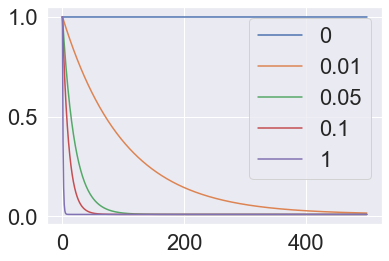

In [51]:
n_runs = range(500)
sample_decays = [0,0.01,0.05,0.1,1]
epsilon_by_decays = []

for decay in sample_decays:
    e_by_run = []
    epsilon = 1
    max_epsilon = 1
    min_epsilon = 0.01
    for episode in n_runs:
        epsilon = min_epsilon + (max_epsilon - min_epsilon)*np.exp(-decay*episode)
        e_by_run.append(epsilon)
    epsilon_by_decays.append(epsilon)
    plt.plot(n_runs, e_by_run, label=decay)
    
plt.legend()
    

Text(0.5, 1.0, 'Impact by Steps')

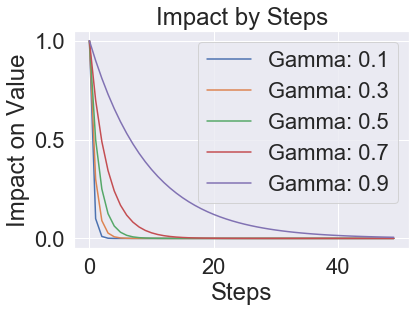

In [52]:
sns.set(font_scale=2)

gammas = np.arange(0.1,1.0,0.2)

g_by_i = []

for g in gammas:
    g_by_i.append([g**i for i in range(50)])
    plt.plot(g_by_i[-1], label=f"Gamma: {np.round(g,1)}")
    
plt.ylabel("Impact on Value")
plt.xlabel("Steps")
plt.legend()
plt.title("Impact by Steps")

# RANDOM ACTIONS (S)

In [53]:
env_s = gym.make('Taxi-v3')
env_s.reset()

294

In [54]:
test = gym.make('Taxi-v3')

In [55]:
action_text = {
    0: "down",
    1: "up",
    2: "right",
    3: "left",
    4: "pickup",
    5: "dropoff"
}

In [56]:
test.reset(seed=8)
test.render()

TypeError: reset() got an unexpected keyword argument 'seed'

In [19]:
for i in range(1):
    a = 2
    state, reward, done, info = test.step(a)
    print(f"State: {state}, Action: {action_text[a]}, Reward: {reward}, Done: {done}")
    test.render()

State: 183, Action: right, Reward: -1, Done: False
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (East)


This is play until you win!

In [19]:
# runs_s_wins_only = []
# for _ in range(100):
#     state = env_s.reset(seed=8)
#     counter = 0
#     reward = None
#     while reward != 20:
#         state, reward, done, info = env_s.step(env_s.action_space.sample())
#         counter += reward

#     runs_s_wins_only.append(counter)

This is play until the game is DONE. Env can terminate (around 800 episodes)

In [20]:
# runs_s_done = []
# wins_s_done=0
# for _ in range(1000):
#     state = env_s.reset(seed=8)
#     counter = 0
#     reward = None
#     done = False
#     while reward != 20 and not done:
#         state, reward, done, info = env_s.step(env_s.action_space.sample())
#         counter += reward
#         wins_s_done += reward == 20

#     runs_s_done.append(counter)

In [21]:
# sns.set(font_scale=1.0)
# plt.hist(runs_s_wins_only,bins=20)
# plt.xticks(rotation=90)
# plt.xlabel("Total Rewards")
# plt.title("Rewards (Play until a Win)")
# plt.show()

In [20]:
env_s.reset(seed=8)
n_episodes = 1000
wins, rewards_random = play_episodes(env_s, n_episodes, None, random = True, rewards_aggrated=False)
print(f'Win Percentage with Random Policy: {wins/n_episodes*100}%')
print(f"Average rewards with Random Policy: {np.mean(rewards_random)}")

Win Percentage with Random Policy: 4.5%
Average rewards with Random Policy: -768.621


# VALUE ITERATION (S)

### By Gamma

In [21]:
vi_deltas_by_gamma = []
# gammas = np.arange(0.11,1.0,0.22)

# Randomly Generated Map
for g in gammas:
    env_s.reset(seed=8)
    optimal_function, d_vi = value_iteration(env_s,discount_factor=g)
    vi_deltas_by_gamma.append(d_vi)
    r = np.mean(optimal_function)
    print(f'Gamma: {g}, Iterations: {len(d_vi)}, Reward: {r}')
    

Gamma: 0.1, Iterations: 7, Reward: -0.8874977499999998
Gamma: 0.30000000000000004, Iterations: 12, Reward: -0.99173061521026
Gamma: 0.5000000000000001, Iterations: 21, Reward: -0.9160071468353269
Gamma: 0.7000000000000001, Iterations: 38, Reward: 0.8971616669369851
Gamma: 0.9000000000000001, Iterations: 127, Reward: 35.934298869751494


Text(0.5, 1.0, 'Figure 4.1.1.1:\nConvergence by Gamma (Taxi-S)')

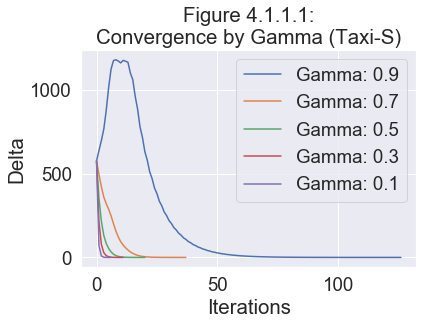

In [22]:
sns.set(font_scale=1.7)
title = "Figure 4.1.1.1:\nConvergence by Gamma (Taxi-S)"

for i in range(len(gammas)-1,-1,-1):
    plt.plot(vi_deltas_by_gamma[i],label=f'Gamma: {np.round(gammas[i],1)}')

plt.legend()
plt.xlabel("Iterations")
plt.ylabel("Delta")
plt.title(title)

plt.savefig(title.replace(".","").replace("\n","")+".svg",bbox_inches="tight")

### By Iteration

In [25]:
env_s.reset()

491

In [60]:
itr_vi = range(2,102,2)

rewards_vi_gamma = []
run_times_vi_gamma = []
values_funs_vi_gamma = []
policies_vi_gamma = []

for g in gammas:
    rewards_vi=[]
    run_time_vi=[]
    for i in itr_vi:
        s = int(1000*g + i)
        env_s.reset(seed=s)
        st_time = time.perf_counter()
        V, d_vi = value_iteration(env_s.env, discount_factor = g, max_iteration = i)
        run_time_vi.append(time.perf_counter() - st_time)
        
        env_s.reset(seed=s)
        opt_policy_vi = extract_policy(V, env_s,gamma=g)
        wins, total_reward, avg_reward = play_episodes(env_s, 10, opt_policy_vi, random = False)
        rewards_vi.append(avg_reward)
    values_funs_vi_gamma.append(V)
    policies_vi_gamma.append(opt_policy_vi)
    rewards_vi_gamma.append(rewards_vi)
    run_times_vi_gamma.append(run_time_vi)
    print(f'Gamma: {g}, Reward: {rewards_vi[-1]}, Win %: {wins/10*100}, Run-time: {np.sum(run_time_vi)}')

Gamma: 0.1, Reward: -179.0, Win %: 10.0, Run-time: 2.2240766500001428
Gamma: 0.30000000000000004, Reward: -32.4, Win %: 80.0, Run-time: 3.6003343559991663
Gamma: 0.5000000000000001, Reward: 8.8, Win %: 100.0, Run-time: 5.9887883659991985
Gamma: 0.7000000000000001, Reward: 7.2, Win %: 100.0, Run-time: 9.715489517999458
Gamma: 0.9000000000000001, Reward: 8.8, Win %: 100.0, Run-time: 16.01984563699989


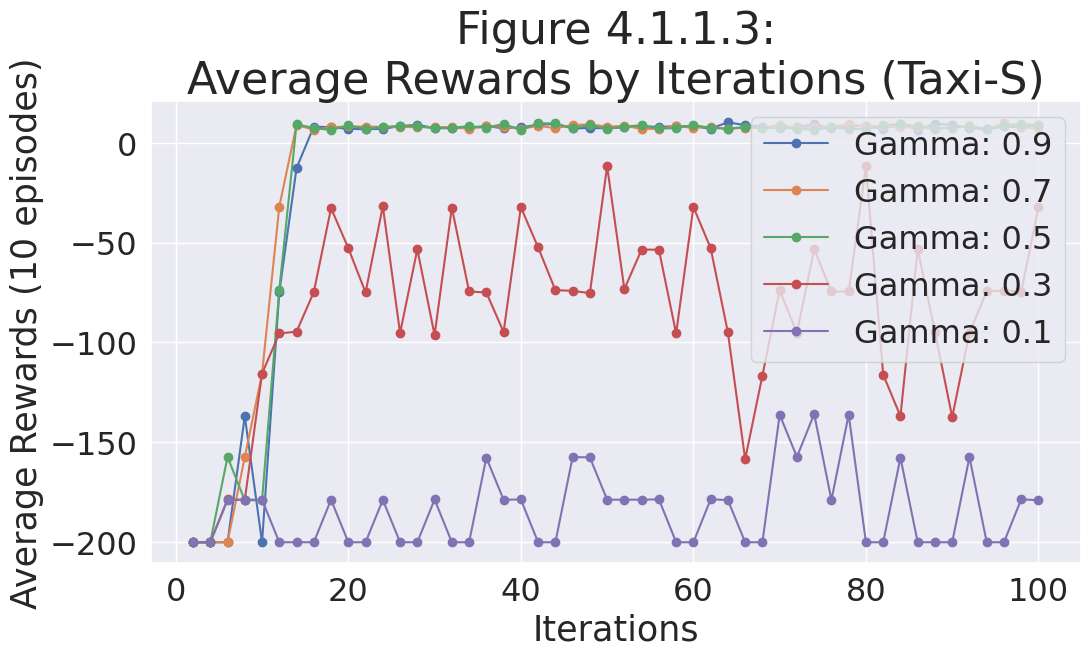

In [27]:
sns.set(font_scale=2.1)
title = "Figure 4.1.1.3:\nAverage Rewards by Iterations (Taxi-S)"

for i in range(len(gammas)-1,-1,-1):
# for i in [3,4]:
    plt.plot(itr_vi,rewards_vi_gamma[i],marker='o', label=f'Gamma: {np.round(gammas[i],1)}')


plt.xlabel('Iterations')
plt.ylabel('Average Rewards (10 episodes)')
plt.title(title,size=32)
plt.legend(loc='upper right')
fig=plt.gcf()
fig.set_size_inches(12,6)

plt.savefig(title.replace(".","").replace("\n","")+".svg",bbox_inches="tight")

In [ ]:
sns.set(font_scale=2.1)
title = "Figure 4.1.1.5:\nTime Taken by Iterations (Taxi-S)"

for i in range(len(gammas)-1,-1,-1):
    plt.plot(itr_vi,run_times_vi_gamma[i],marker='o', label=f'Gamma: {np.round(gammas[i],1)}')


plt.xlabel('Iterations')
plt.ylabel('Time Taken(Seconds)')
plt.title(title,size=32)
plt.legend()
fig=plt.gcf()
fig.set_size_inches(12,6)
plt.savefig(title.replace(".","").replace("\n","")+".svg",bbox_inches="tight")

In [23]:
env_s.reset(seed=8)
V_vi = None
times_vi = []
for _ in range(5):
    s_time = time.perf_counter()
    V_vi,_ = value_iteration(env_s,discount_factor=0.7)
    times_vi.append(time.perf_counter() - s_time)
    
policy_vi_s = extract_policy(V_vi, env_s)


In [24]:
env_s.reset(seed=8)

n_episodes = 1000
wins, rewards_vi = play_episodes(env_s, n_episodes, policy_vi_s, random = False,rewards_aggrated=False)
print(f'Win Percentage with Value Iteration: {wins/n_episodes*100}%')
print(f"Average rewards with Value Iteration: {np.mean(rewards_vi)}")
print(f"Average times with Value Iteration: {np.mean(times_vi)}")

Win Percentage with Value Iteration: 100.0%
Average rewards with Value Iteration: 7.843
Average times with Value Iteration: 0.38605136000000184


## POLICY ITERATION (S)

### By Gamma

In [30]:
#Calling Functions to get the optimum policy
np.random.seed(8)

pi_deltas_by_gamma = []
pi_iterations_by_gamma = []
pi_ave_reward_by_gamma = []
pi_times_by_gamma = []
pi_evals_by_gamma = []
# gammas = [1]

# Randomly Generated Map
for g in gammas:
    s = int(1000*g)
    env_s.reset(seed=s)
    st_time = time.perf_counter()
    V, _, d_pi = policy_iteration(env_s,discount_factor=g, early_stopping=True)
    pi_times_by_gamma.append(time.perf_counter()-st_time)
    pi_iterations_by_gamma.append(len(d_pi))
    pi_deltas_by_gamma.append(d_pi)
    r = np.mean(V)
    pi_ave_reward_by_gamma.append(r)
    print(f'Gamma: {g}, Iterations: {len(d_pi)}, Reward: {r}')

Gamma: 0.1, Iterations: 19, Reward: -0.8874973726584173
Gamma: 0.30000000000000004, Iterations: 19, Reward: -0.9917249869941386
Gamma: 0.5000000000000001, Iterations: 19, Reward: -0.9160740203857419
Gamma: 0.7000000000000001, Iterations: 19, Reward: 0.8441285666418928
Gamma: 0.9000000000000001, Iterations: 19, Reward: 21.535314359046467


Text(0.5, 1.0, 'Figure 4.1.2.1:\nConvergence by Gamma (Taxi-S)')

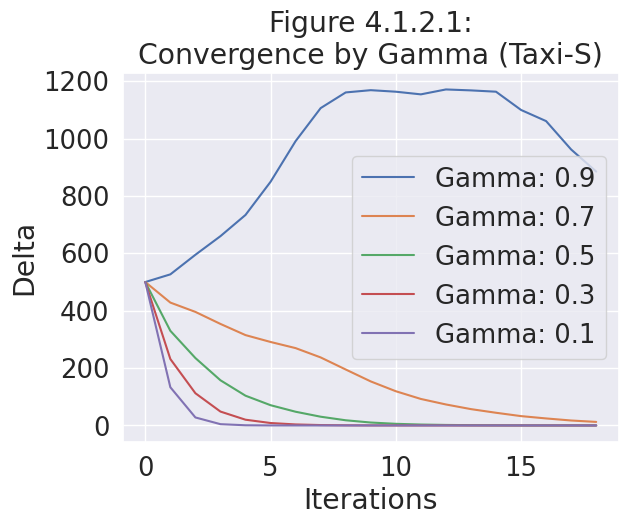

In [31]:
sns.set(font_scale=1.7)
title = "Figure 4.1.2.1:\nConvergence by Gamma (Taxi-S)"

for i in range(len(gammas)-1,-1,-1):
    plt.plot(pi_deltas_by_gamma[i],label=f'Gamma: {np.round(gammas[i],1)}')

plt.legend()
plt.xlabel("Iterations")
plt.ylabel("Delta")
plt.title(title)

plt.savefig(title.replace(".","").replace("\n","")+".svg",bbox_inches="tight")

### By Iterations

In [32]:
# itr_pi = range(35)

rewards_pi_gamma = []
run_times_pi_gamma = []
values_funs_pi_gamma = []
policies_pi_gamma = []

for g in gammas:
    rewards_pi=[]
    run_time_pi=[]
    for i in itr_vi:
        s = int(1000*g + i)
        env_s.reset(seed=s)
        st_time = time.perf_counter()
        V, opt_policy_pi, _ = policy_iteration(env_s,discount_factor=g, max_iteration = i,early_stopping=True)
        run_time_pi.append(time.perf_counter() - st_time)
        
        env_s.reset(seed=s)
        wins, total_reward, avg_reward = play_episodes(env_s, 10, opt_policy_pi, random = False)
        rewards_pi.append(avg_reward)
    values_funs_pi_gamma.append(V)
    policies_pi_gamma.append(opt_policy_pi)
    rewards_pi_gamma.append(rewards_pi)
    run_times_pi_gamma.append(run_time_pi)
    print(f'Gamma: {g}, Reward: {rewards_pi[-1]}, Run-time: {np.sum(run_time_pi)}')

Gamma: 0.1, Reward: 8.2, Run-time: 9.672263614999906
Gamma: 0.30000000000000004, Reward: 6.6, Run-time: 9.636543624000183
Gamma: 0.5000000000000001, Reward: 8.8, Run-time: 9.530280465999908
Gamma: 0.7000000000000001, Reward: 7.2, Run-time: 9.573360582999953
Gamma: 0.9000000000000001, Reward: 8.8, Run-time: 9.719651408000004


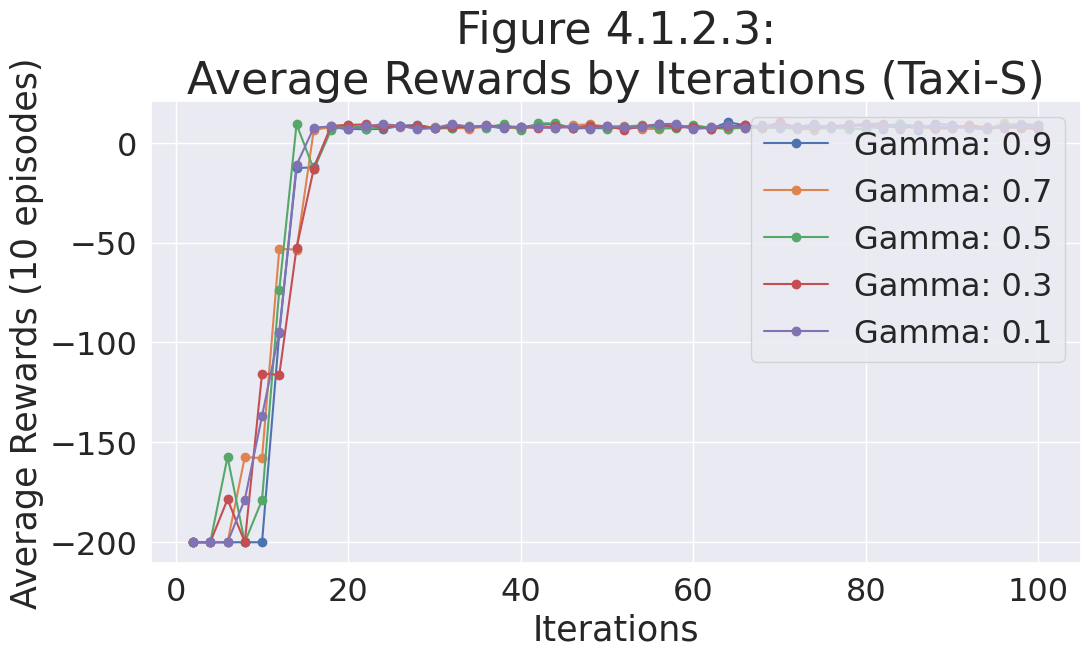

In [33]:
sns.set(font_scale=2.1)
title = "Figure 4.1.2.3:\nAverage Rewards by Iterations (Taxi-S)"

for i in range(len(gammas)-1,-1,-1):
# for i in [3,4]:
    plt.plot(itr_vi,rewards_pi_gamma[i],marker='o', label=f'Gamma: {np.round(gammas[i],1)}')


plt.xlabel('Iterations')
plt.ylabel('Average Rewards (10 episodes)')
plt.title(title,size=32)
plt.legend(loc='upper right')
fig=plt.gcf()
fig.set_size_inches(12,6)

plt.savefig(title.replace(".","").replace("\n","")+".svg",bbox_inches="tight")

In [ ]:
sns.set(font_scale=2.1)
title = "Figure 4.1.2.5:\nTime Taken by Iterations (Taxi-S)"

for i in range(len(gammas)-1,-1,-1):
    plt.plot(itr_vi,run_times_pi_gamma[i],marker='o', label=f'Gamma: {np.round(gammas[i],1)}')


plt.xlabel('Iterations')
plt.ylabel('Time Taken(Seconds)')
plt.title(title,size=32)
plt.legend()
fig=plt.gcf()
fig.set_size_inches(12,6)
plt.savefig(title.replace(".","").replace("\n","")+".svg",bbox_inches="tight")

In [34]:
env_s.reset(seed=8)
V_pi = None
times_pi = []
for _ in range(5):
    s_time = time.perf_counter()
    V_pi, policy_pi_s, _ = policy_iteration(env_s,discount_factor=0.9,early_stopping=True)
    times_pi.append(time.perf_counter() - s_time)
    
# policy_pi = extract_policy(V_pi, env)


In [35]:
env_s.reset(seed=8)

n_episodes = 1000
wins, rewards_pi = play_episodes(env_s, n_episodes, policy_pi_s, random = False,rewards_aggrated=False)
print(f'Win Percentage with Policy Iteration: {wins/n_episodes*100}%')
print(f"Average rewards with Policy Iteration: {np.mean(rewards_pi)}")
print(f"Average times with Policy Iteration: {np.mean(times_pi)}")

Win Percentage with Policy Iteration: 100.0%
Average rewards with Policy Iteration: 7.843
Average times with Policy Iteration: 0.2138433454000051


# Q-LEARNING (S)

In [77]:
learning_rates = np.arange(0.09,1.0,0.1)
# learning_rates = [0.1,0.25,0.5,0.75,0.9]
ave_rewards_lr = []
rewards_lr = []
# q_tables_lr = []
times_lr = []
deltas_lr = []
for learning_rate in learning_rates:
    env_s.reset(seed=int(learning_rate*1000))
    reward, t, _, deltas = q_learning(env_s, learning_rate = learning_rate, early_stopping=False)
    deltas_lr.append(deltas)
    rewards_lr.append(reward)
    ave_rewards_lr.append(np.mean(reward[-50:]))
#     q_tables_lr.append(q)
#     times_lr.append(np.sum(t))
    times_lr.append(len(t))
    print(f"{learning_rate}: {np.mean(reward[-50:])}")

0.09: -36.74
0.19: 2.6
0.29000000000000004: 6.74
0.39: 7.46
0.49: 6.96
0.59: 8.04
0.6900000000000001: 7.14
0.79: 7.58
0.89: 7.22
0.99: 7.46


Text(0.5, 1.0, 'Figure 4.1.3.3:\nAverage Reward by Learning Rate\n(Taxi-S)')

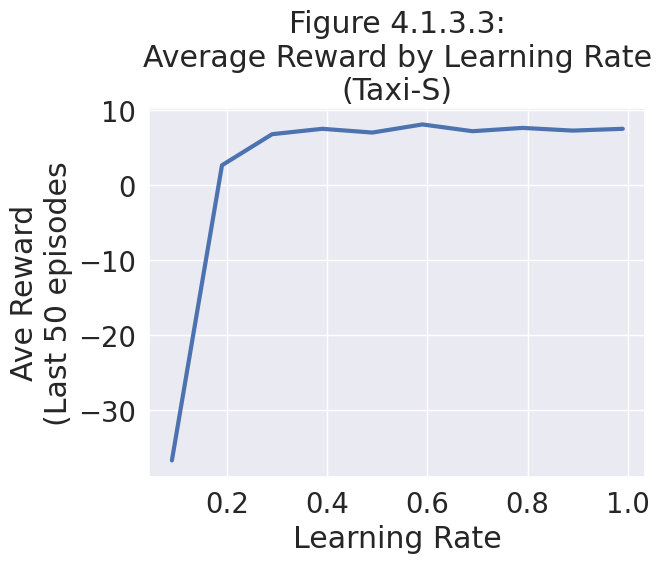

In [78]:
sns.set(font_scale=1.8)
title = "Figure 4.1.3.3:\nAverage Reward by Learning Rate\n(Taxi-S)"

plt.plot(learning_rates, ave_rewards_lr, lw=3, label="Rewards")

plt.xlabel("Learning Rate")
plt.ylabel("Ave Reward\n(Last 50 episodes")

plt.title(title)
plt.savefig(title.replace(".","").replace("\n","")+".svg",bbox_inches="tight")

Text(0.5, 1.0, 'Figure 4.1.3.1:\nDelta by Learning Rate (Taxi-S)')

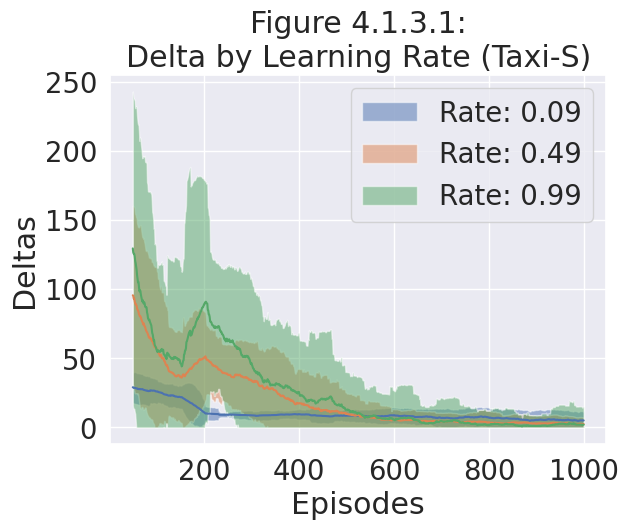

In [250]:
sns.set(font_scale=1.8)
title = "Figure 4.1.3.1:\nDelta by Learning Rate (Taxi-S)"

for n in [0,4,9]:
    rates = pd.DataFrame(deltas_lr[n])
    rates_sma = get_sma(rates, 50)
    st_up, st_down = get_bollinger_bands(rates,50)

    plt.plot(rates_sma)
    plt.fill_between(np.arange(1000), st_up[0], st_down[0], alpha=0.5,label=f'Rate: {np.round(learning_rates[n],2)}')
    
plt.legend()
plt.xlabel("Episodes")
plt.ylabel("Deltas")
plt.title(title)
plt.savefig(title.replace(".","").replace("\n","")+".svg",bbox_inches="tight")

In [ ]:
# for n in [0,4,9]:
#     plt.plot(deltas_lr[n][:500], label=f'Alpha: {learning_rates[n]}')
    
# plt.xlabel("Episodes")
# plt.ylabel("Delta")
# plt.legend()

In [ ]:
# COLOR_REWARD = "blue"
# COLOR_TIME = "orange"

# fig, ax1 = plt.subplots(figsize=(8, 8))
# ax2 = ax1.twinx()

# ax1.plot(learning_rates, total_rewards_lr, color=COLOR_REWARD, lw=3, label="Rewards")
# ax2.plot(learning_rates, times_lr, color=COLOR_TIME, lw=4, label="Time")

# ax1.set_xlabel("Learning Rate")
# ax1.set_ylabel("Ave Reward (Last 50 episodes)", color=COLOR_REWARD, fontsize=14)
# ax1.tick_params(axis="y", labelcolor=COLOR_REWARD)

# ax2.set_ylabel("Time (seconds)", color=COLOR_TIME, fontsize=14)
# ax2.tick_params(axis="y", labelcolor=COLOR_TIME)

# fig.suptitle("Reward & Time by Learning Rate", fontsize=20)

When the learning rate 

In [ ]:
discount_rates = np.arange(0.05,0.96,0.05)
ave_rewards_dr = []
rewards_dr = []
deltas_dr = []
q_tables_dr = []
times_dr = []
for d in discount_rates:
    reward, t, q, deltas = q_learning(env_s, discount_factor = d,early_stopping=False)
    ave_rewards_dr.append(np.mean(reward[-50:]))
    rewards_dr.append(reward)
    deltas_dr.append(deltas)
    q_tables_dr.append(q)
#     times_dr.append(np.mean(t))
    times_dr.append(len(t))
    print(f"{d}: {np.mean(reward[-50:])}")

In [ ]:
sns.set(font_scale=1.8)
title = "Figure 4.1.3.7:\nAverage Reward by Discount Rate\n(Taxi-S)"

plt.plot(discount_rates, ave_rewards_dr, lw=3, label="Rewards")

plt.xlabel("Discount Rate")
plt.ylabel("Ave Reward\n(Last 50 episodes")

plt.title(title)
plt.savefig(title.replace(".","").replace("\n","")+".svg",bbox_inches="tight")

In [ ]:
sns.set(font_scale=1.8)
title = "Figure 4.1.3.5:\nDelta by Discount Rate (Taxi-S)"

for n in [0,9,18]:
    rates = pd.DataFrame(deltas_dr[n])
    rates_sma = get_sma(rates, 50)
    st_up, st_down = get_bollinger_bands(rates,50)

    plt.plot(rates_sma)
    plt.fill_between(np.arange(1000), st_up[0], st_down[0], alpha=0.5,label=f'Rate: {np.round(discount_rates[n],2)}')
    
plt.legend()
plt.xlabel("Episodes")
plt.ylabel("Deltas")
plt.title(title)
plt.savefig(title.replace(".","").replace("\n","")+".svg",bbox_inches="tight")

In [ ]:
# exploration_decay_rates = np.arange(0,0.1001,0.005)
exploration_decay_rates = np.arange(0.00158,0.102,0.01)
ave_rewards_edr = []
deltas_edr = []
q_tables_edr = []
times_edr = []
env_s.reset(seed=8)
for d in exploration_decay_rates:
    reward, t, q, deltas = q_learning(env_s, decay = d, early_stopping=False)
    ave_rewards_edr.append(np.mean(reward[-50:]))
    deltas_edr.append(deltas)
    q_tables_edr.append(q)
#     times_edr.append(np.mean(t))
    times_edr.append(len(t))
    print(f"{d}: {np.mean(reward[-50:])}")

In [ ]:
sns.set(font_scale=1.8)
title = "Figure 4.1.3.11:\nAverage Reward by Decay Rate\n(Taxi-S)"

plt.plot(exploration_decay_rates, ave_rewards_edr, lw=3, label="Rewards")

plt.xlabel("Decay Rate")
plt.ylabel("Ave Reward\n(Last 50 episodes")

plt.title(title)
plt.savefig(title.replace(".","").replace("\n","")+".svg",bbox_inches="tight")

In [ ]:
sns.set(font_scale=1.8)
title = "Figure 4.1.3.9:\nDelta by Decay Rate (Taxi-S)"

for n in [0,5,10]:
    rates = pd.DataFrame(deltas_edr[n])
    rates_sma = get_sma(rates, 50)
    st_up, st_down = get_bollinger_bands(rates,50)

    plt.plot(rates_sma)
    plt.fill_between(np.arange(1000), st_up[0], st_down[0], alpha=0.5,label=f'Rate: {np.round(exploration_decay_rates[n],3)}')
    
plt.legend()
plt.xlabel("Episodes")
plt.ylabel("Deltas")
plt.title(title)
plt.savefig(title.replace(".","").replace("\n","")+".svg",bbox_inches="tight")

In [83]:
env_s.reset(seed=8)
V_ql = None
times_ql = []
for _ in range(5):
    s_time = time.perf_counter()
    _,_,_,_ = q_learning(env_s, learning_rate=0.5, discount_factor=0.99, decay=0.01, train_episodes=1500)
    times_ql.append(time.perf_counter() - s_time)

In [169]:
env_s.reset(seed=354)

_,_,Q,_ = q_learning(env_s, learning_rate=0.8, discount_factor=0.99, decay=0.01, train_episodes=1500)

policy_ql_s = np.argmax(Q,axis=1)

n_episodes = 1000
wins, rewards_ql = play_episodes(env_s, n_episodes, policy_ql_s, random = False,rewards_aggrated=False)
print(f'Win Percentage with Q-Learning: {wins/n_episodes*100}%')
print(f"Average rewards with Q-Learning: {np.mean(rewards_ql)}")
print(f"Average times with Q-Learning: {np.mean(times_ql)}")

Win Percentage with Q-Learning: 99.3%
Average rewards with Q-Learning: 6.355
Average times with Q-Learning: 1.477385208600026


# Comparing S policies

In [170]:
policy_vi_s[policy_vi_s>=4].shape

(20,)

In [247]:
np.mean(policy_vi_s[policy_vi_s==5]==policy_ql_s[policy_vi_s==5])

1.0

In [233]:
policies_s = pd.DataFrame(np.array((policy_vi_s,policy_pi_s,policy_ql_s)).transpose(),columns=["VI","PI","QL"])

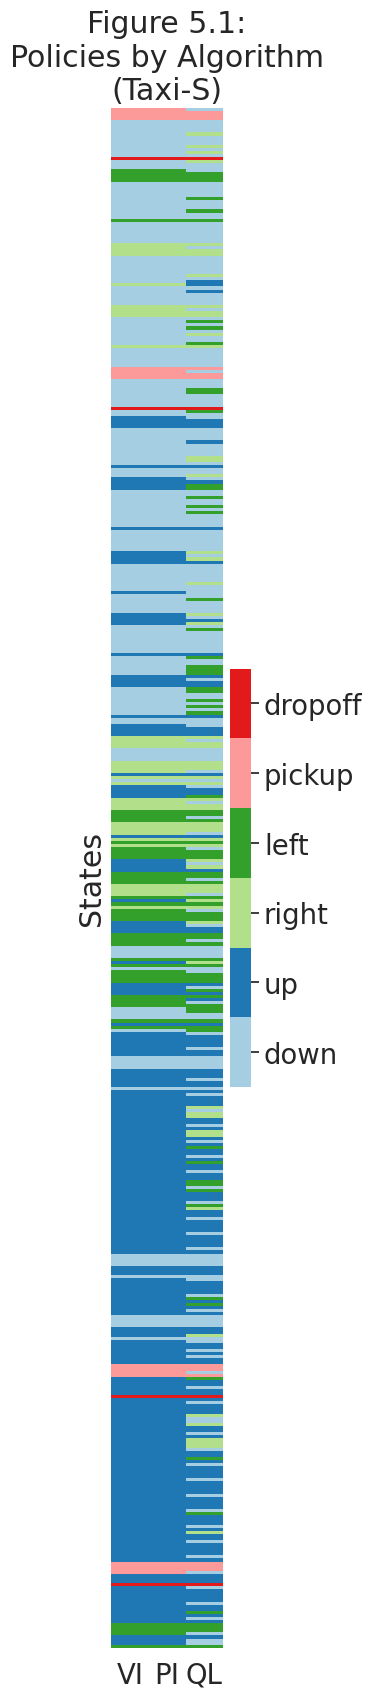

In [238]:
sns.set(font_scale=1.8)
title = "Figure 5.1:\nPolicies by Algorithm\n(Taxi-S)"

plt.figure(figsize=(1.8,20))

cmap = sns.color_palette("Paired", 6) 
ax = sns.heatmap(policies_s,cmap=cmap,yticklabels=False) 
# modify colorbar:
colorbar = ax.collections[0].colorbar 
r = colorbar.vmax - colorbar.vmin 
colorbar.set_ticks([colorbar.vmin + r / 6 * (0.5 + i) for i in range(6)])
colorbar.set_ticklabels(list(action_text.values())) 
plt.ylabel("States")
plt.title(title)
plt.savefig(title.replace(".","").replace("\n","")+".svg",bbox_inches="tight")

In [174]:
np.mean(policy_pi_s==policy_ql_s)

0.706

=======================================================================================================================================
=======================================================================================================================================
=======================================================================================================================================
=======================================================================================================================================

# Large Enviroment

In [25]:
!pip install gym==0.21.0

     ---------------------------------------- 1.5/1.5 MB 5.8 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for gym: filename=gym-0.21.0-py3-none-any.whl size=1616828 sha256=488980746e880dc2ff0c2e465db45149e66ef0819b203a03b112e4794e59e204
  Stored in directory: c:\users\steve\appdata\local\pip\cache\wheels\76\ee\9c\36bfe3e079df99acf5ae57f4e3464ff2771b34447d6d2f2148
Successfully built gym
  Attempting uninstall: gym
    Found existing installation: gym 0.23.1
    Uninstalling gym-0.23.1:
      Successfully uninstalled gym-0.23.1


In [26]:
import sys
from contextlib import closing
from io import StringIO
from gym import utils
from gym.envs.toy_text import discrete
import numpy as np

MAP = [
    "+-----------------+",
    "|R: | : : : : |G: |",
    "| : | : : : : | : |",
    "| : : : : : | | | |",
    "| | : : : | : | | |",
    "| : : | : | : : | |",
    "| : : : | : | : : |",
    "| : : : : | : : | |",
    "| : : | : | | : : |",
    "| : | : : | : : | |",
    "| : : : : : : | : |",
    "| | : : : | : | | |",
    "|Y| : |B| : : : | |",
    "| | | : : | : : | |",
    "| : : | : : | : : |",
    "+-----------------+",
]


class TaxiEnv2(discrete.DiscreteEnv):
    """
    The Taxi Problem
    from "Hierarchical Reinforcement Learning with the MAXQ Value Function Decomposition"
    by Tom Dietterich
    Description:
    There are four designated locations in the grid world indicated by R(ed), G(reen), Y(ellow), and B(lue). When the episode starts, the taxi starts off at a random square and the passenger is at a random location. The taxi drives to the passenger's location, picks up the passenger, drives to the passenger's destination (another one of the four specified locations), and then drops off the passenger. Once the passenger is dropped off, the episode ends.
    Observations:
    There are 500 discrete states since there are 25 taxi positions, 5 possible locations of the passenger (including the case when the passenger is in the taxi), and 4 destination locations.
    Note that there are 400 states that can actually be reached during an episode. The missing states correspond to situations in which the passenger is at the same location as their destination, as this typically signals the end of an episode.
    Four additional states can be observed right after a successful episodes, when both the passenger and the taxi are at the destination.
    This gives a total of 404 reachable discrete states.
    Passenger locations:
    - 0: R(ed)
    - 1: G(reen)
    - 2: Y(ellow)
    - 3: B(lue)
    - 4: in taxi
    Destinations:
    - 0: R(ed)
    - 1: G(reen)
    - 2: Y(ellow)
    - 3: B(lue)
    Actions:
    There are 6 discrete deterministic actions:
    - 0: move south
    - 1: move north
    - 2: move east
    - 3: move west
    - 4: pickup passenger
    - 5: drop off passenger
    Rewards:
    There is a default per-step reward of -1,
    except for delivering the passenger, which is +20,
    or executing "pickup" and "drop-off" actions illegally, which is -10.
    Rendering:
    - blue: passenger
    - magenta: destination
    - yellow: empty taxi
    - green: full taxi
    - other letters (R, G, Y and B): locations for passengers and destinations
    state space is represented by:
        (taxi_row, taxi_col, passenger_location, destination)
    """

    metadata = {"render.modes": ["human", "ansi"]}

    def __init__(self):
        self.desc = np.asarray(MAP, dtype="c")

        self.locs = locs = [(0, 0), (0, 7), (11, 0), (11, 3)]

        num_states = 2520
        num_rows = 14
        num_columns = 9
        max_row = num_rows - 1
        max_col = num_columns - 1
        initial_state_distrib = np.zeros(num_states)
        num_actions = 6
        P = {
            state: {action: [] for action in range(num_actions)}
            for state in range(num_states)
        }
        for row in range(num_rows):
            for col in range(num_columns):
                for pass_idx in range(len(locs) + 1):  # +1 for being inside taxi
                    for dest_idx in range(len(locs)):
                        state = self.encode(row, col, pass_idx, dest_idx)
                        if pass_idx < 4 and pass_idx != dest_idx:
                            initial_state_distrib[state] += 1
                        for action in range(num_actions):
                            # defaults
                            new_row, new_col, new_pass_idx = row, col, pass_idx
                            reward = (
                                -1
                            )  # default reward when there is no pickup/dropoff
                            done = False
                            taxi_loc = (row, col)

                            if action == 0:
                                new_row = min(row + 1, max_row)
                            elif action == 1:
                                new_row = max(row - 1, 0)
                            if action == 2 and self.desc[1 + row, 2 * col + 2] == b":":
                                new_col = min(col + 1, max_col)
                            elif action == 3 and self.desc[1 + row, 2 * col] == b":":
                                new_col = max(col - 1, 0)
                            elif action == 4:  # pickup
                                if pass_idx < 4 and taxi_loc == locs[pass_idx]:
                                    new_pass_idx = 4
                                else:  # passenger not at location
                                    reward = -10
                            elif action == 5:  # dropoff
                                if (taxi_loc == locs[dest_idx]) and pass_idx == 4:
                                    new_pass_idx = dest_idx
                                    done = True
                                    reward = 20
                                elif (taxi_loc in locs) and pass_idx == 4:
                                    new_pass_idx = locs.index(taxi_loc)
                                else:  # dropoff at wrong location
                                    reward = -10
                            new_state = self.encode(
                                new_row, new_col, new_pass_idx, dest_idx
                            )
                            P[state][action].append((1.0, new_state, reward, done))
        initial_state_distrib /= initial_state_distrib.sum()
        discrete.DiscreteEnv.__init__(
            self, num_states, num_actions, P, initial_state_distrib
        )

    def encode(self, taxi_row, taxi_col, pass_loc, dest_idx):
        # (5) 5, 5, 4
        i = taxi_row
        i *= 9
        i += taxi_col
        i *= 5
        i += pass_loc
        i *= 4
        i += dest_idx
        return i

    def decode(self, i):
        out = []
        out.append(i % 4)
        i = i // 4
        out.append(i % 5)
        i = i // 5
        out.append(i % 9)
        i = i // 9
        out.append(i)
        assert 0 <= i < 14
        return reversed(out)

    def render(self, mode="human"):
        outfile = StringIO() if mode == "ansi" else sys.stdout

        out = self.desc.copy().tolist()
        out = [[c.decode("utf-8") for c in line] for line in out]
        taxi_row, taxi_col, pass_idx, dest_idx = self.decode(self.s)

        def ul(x):
            return "_" if x == " " else x

        if pass_idx < 4:
            out[1 + taxi_row][2 * taxi_col + 1] = utils.colorize(
                out[1 + taxi_row][2 * taxi_col + 1], "yellow", highlight=True
            )
            pi, pj = self.locs[pass_idx]
            out[1 + pi][2 * pj + 1] = utils.colorize(
                out[1 + pi][2 * pj + 1], "blue", bold=True
            )
        else:  # passenger in taxi
            out[1 + taxi_row][2 * taxi_col + 1] = utils.colorize(
                ul(out[1 + taxi_row][2 * taxi_col + 1]), "green", highlight=True
            )

        di, dj = self.locs[dest_idx]
        out[1 + di][2 * dj + 1] = utils.colorize(out[1 + di][2 * dj + 1], "magenta")
        outfile.write("\n".join(["".join(row) for row in out]) + "\n")
        if self.lastaction is not None:
            outfile.write(
                f"  ({['South', 'North', 'East', 'West', 'Pickup', 'Dropoff'][self.lastaction]})\n"
            )
        else:
            outfile.write("\n")

        # No need to return anything for human
        if mode != "human":
            with closing(outfile):
                return outfile.getvalue()

In [27]:
gym.register(
    id="Taxi-v4",
    entry_point=TaxiEnv2, # optimum = 8.46
    max_episode_steps=300,
)

# RANDOM ACTIONS (LG)

In [28]:
env_lg = gym.make('Taxi-v4')

c:\users\steve\appdata\local\programs\python\python37\lib\site-packages\gym\utils\seeding.py:28: DeprecationWarning: WARN: Function `rng.rand(*size)` is marked as deprecated and will be removed in the future. Please use `Generator.random(size)` instead.
  linear correlations between seeds of multiple PRNG's can correlate


In [29]:
env_lg.reset()

1682

In [30]:
env_lg.render()

+-----------------+
|R: | : : : : |G: |
| : | : : : : | : |
| : : : : : | | | |
| | : : : | : | | |
| : : | : | : : | |
| : : : | : | : : |
| : : : : | : : | |
| : : | : | | : : |
| : | : : | : : | |
| : : : : : : | : |
| | : : : | : | | |
|Y| : |B| : : : | |
| | | : : | : : | |
| : : | : : | : : |
+-----------------+



This is play until you win!

In [ ]:
env_lg.observation_space.n

Grid is (14 x 9)

In [ ]:
14*9*4*5

In [ ]:
# runs_lg_wins_only = []
# for _ in range(100):
#     state = env_lg.reset(seed=8)
#     counter = 0
#     reward = None
#     while reward != 20 and counter < 50000:
#         state, reward, done, info = env_lg.step(env_lg.action_space.sample())
#         counter += reward

#     runs_lg_wins_only.append(counter)

In [ ]:
# sns.set(font_scale=1.0)
# plt.hist(runs_lg_wins_only,bins=20,alpha=1.0,label="2520 states")
# # plt.hist(runs_s_wins_only, bins=5, alpha=0.5,label="500 states")
# plt.xticks(rotation=90)
# plt.xlabel("Total Rewards")
# # plt.legend()
# plt.title("Rewards (Play until a Win)")
# plt.show()

This is play until the game is DONE. Env can terminate (around 800 episodes)

In [ ]:
# runs_lg_done = []
# wins_lg=0
# for _ in range(1000):
#     state = env_lg.reset(seed=8)
#     counter = 0
#     reward = None
#     done = False
#     while reward != 20 and not done:
#         state, reward, done, info = env_lg.step(env_lg.action_space.sample())
#         counter += reward
#         wins_lg += reward == 20

#     runs_lg_done.append(counter)

In [ ]:
# sns.set(font_scale=1.0)
# plt.hist(runs_lg_done,bins=20)
# # plt.hist(runs_s_done,bins=20)
# plt.xticks(rotation=90)
# plt.xlabel("Total Rewards")
# plt.title("Rewards (Play until a Win)")
# plt.show()

In [31]:
env_lg.reset()
n_episodes = 1000
wins, rewards_random = play_episodes(env_lg, n_episodes, None, random = True, rewards_aggrated=False)
print(f'Win Percentage with Random Policy: {wins/n_episodes*100}%')
print(f"Average rewards with Random Policy: {np.mean(rewards_random)}")

Win Percentage with Random Policy: 0.7000000000000001%
Average rewards with Random Policy: -1187.712


# VALUE ITERATION (LG)

### By Gamma

In [32]:
vi_deltas_by_gamma = []
# gammas = np.arange(0.11,1.0,0.22)
gammas = np.arange(0.1,1.0,0.2)

# Randomly Generated Map
for g in gammas:
    env_lg.reset()
    optimal_function, d_vi = value_iteration(env_lg,discount_factor=g)
    vi_deltas_by_gamma.append(d_vi)
    r = np.mean(optimal_function)
    print(f'Gamma: {g}, Iterations: {len(d_vi)}, Reward: {r}')
    

Gamma: 0.1, Iterations: 7, Reward: -1.06539535
Gamma: 0.30000000000000004, Iterations: 13, Reward: -1.3315785959376665
Gamma: 0.5000000000000001, Iterations: 22, Reward: -1.7321878830591837
Gamma: 0.7000000000000001, Iterations: 43, Reward: -2.0840862180160578
Gamma: 0.9000000000000001, Iterations: 142, Reward: 12.623658839088078


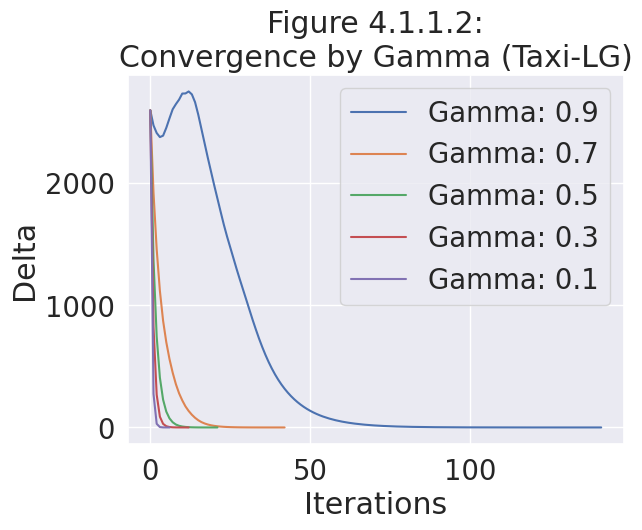

In [177]:
title = "Figure 4.1.1.2:\nConvergence by Gamma (Taxi-LG)"

for i in range(len(gammas)-1,-1,-1):
    plt.plot(vi_deltas_by_gamma[i],label=f'Gamma: {np.round(gammas[i],1)}')

plt.legend()
plt.xlabel("Iterations")
plt.ylabel("Delta")
plt.title(title)

plt.savefig(title.replace(".","").replace("\n","")+".svg",bbox_inches="tight")

### By Iteration

In [ ]:
itr_vi = range(2,102,2)

rewards_vi_gamma = []
run_times_vi_gamma = []
values_funs_vi_gamma = []
policies_vi_gamma = []

for g in gammas:
    rewards_vi=[]
    run_time_vi=[]
    for i in itr_vi:
        env_lg.reset()
        st_time = time.perf_counter()
        V, d_vi = value_iteration(env_lg.env, discount_factor = g, max_iteration = i)
        run_time_vi.append(time.perf_counter() - st_time)
        
        env_lg.reset()
        opt_policy_vi = extract_policy(V, env_lg,gamma=g)
        wins, total_reward, avg_reward = play_episodes(env_lg, 10, opt_policy_vi, random = False)
        rewards_vi.append(avg_reward)
    values_funs_vi_gamma.append(V)
    policies_vi_gamma.append(opt_policy_vi)
    rewards_vi_gamma.append(rewards_vi)
    run_times_vi_gamma.append(run_time_vi)
    print(f'Gamma: {g}, Reward: {rewards_vi[-1]}, Win %: {wins/10*100}, Run-time: {np.sum(run_time_vi)}')

In [ ]:
sns.set(font_scale=2.1)
title = "Figure 4.1.1.4:\nAverage Rewards by Iterations (Taxi-LG)"

for i in range(len(gammas)-1,-1,-1):
# for i in [3,4]:
    plt.plot(itr_vi,rewards_vi_gamma[i],marker='o', label=f'Gamma: {np.round(gammas[i],1)}')


plt.xlabel('Iterations')
plt.ylabel('Average Rewards (10 episodes)')
plt.title(title,size=32)
plt.legend(loc='upper right')
fig=plt.gcf()
fig.set_size_inches(12,6)

plt.savefig(title.replace(".","").replace("\n","")+".svg",bbox_inches="tight")

In [ ]:
sns.set(font_scale=2.1)
title = "Figure 4.1.1.6:\nTime Taken by Iterations (Taxi-LG)"

for i in range(len(gammas)-1,-1,-1):
    plt.plot(itr_vi,run_times_vi_gamma[i],marker='o', label=f'Gamma: {np.round(gammas[i],1)}')


plt.xlabel('Iterations')
plt.ylabel('Time Taken(Seconds)')
plt.title(title,size=32)
plt.legend()
fig=plt.gcf()
fig.set_size_inches(12,6)
plt.savefig(title.replace(".","").replace("\n","")+".svg",bbox_inches="tight")

In [195]:
env_lg.reset()
V_vi = None
times_vi = []
for _ in range(5):
    s_time = time.perf_counter()
    V_vi,_ = value_iteration(env_lg,discount_factor=0.8)
    times_vi.append(time.perf_counter() - s_time)
    
policy_vi_lg = extract_policy(V_vi, env_lg)


In [196]:
env_lg.reset()

n_episodes = 1000
wins, rewards_vi = play_episodes(env_lg, n_episodes, policy_vi_lg, random = False,rewards_aggrated=False)
print(f'Win Percentage with Value Iteration: {wins/n_episodes*100}%')
print(f"Average rewards with Value Iteration: {np.mean(rewards_vi)}")
print(f"Average times with Value Iteration: {np.mean(times_vi)}")

Win Percentage with Value Iteration: 100.0%
Average rewards with Value Iteration: -4.442
Average times with Value Iteration: 2.876991764000195


## POLICY ITERATION (LG)

### By Gamma

In [ ]:
#Calling Functions to get the optimum policy
np.random.seed(8)

pi_deltas_by_gamma = []
pi_iterations_by_gamma = []
pi_ave_reward_by_gamma = []
pi_times_by_gamma = []
pi_evals_by_gamma = []
# gammas = [1]

# Randomly Generated Map
for g in gammas:
    env_lg.reset()
    st_time = time.perf_counter()
    V, _, d_pi = policy_iteration(env_lg,discount_factor=g)
    pi_times_by_gamma.append(time.perf_counter()-st_time)
    pi_iterations_by_gamma.append(len(d_pi))
    pi_deltas_by_gamma.append(d_pi)
    r = np.mean(V)
    pi_ave_reward_by_gamma.append(r)
    print(f'Gamma: {g}, Iterations: {len(d_pi)}, Reward: {r}')

### TO DO: look into why all of them have the same deltas

Rationale:
VI only need a few iterations for each of the gammas to converge so PI is finding similar policies quickly.

In [ ]:
sns.set(font_scale=1.7)
title = "Figure 4.1.2.2:\nConvergence by Gamma (Taxi-LG)"

for i in range(len(gammas)-1,-1,-1):
    plt.plot(pi_deltas_by_gamma[i],label=f'Gamma: {np.round(gammas[i],1)}')

plt.legend()
plt.xlabel("Iterations")
plt.ylabel("Delta")
plt.title(title)

plt.savefig(title.replace(".","").replace("\n","")+".svg",bbox_inches="tight")

### By Iterations

In [ ]:
# itr_pi = range(35)

rewards_pi_gamma = []
run_times_pi_gamma = []
values_funs_pi_gamma = []
policies_pi_gamma = []

for g in gammas:
    rewards_pi=[]
    run_time_pi=[]
    for i in itr_vi:
        env_lg.reset()
        st_time = time.perf_counter()
        V, opt_policy_pi, _ = policy_iteration(env_lg,discount_factor=g, max_iteration = i)
        run_time_pi.append(time.perf_counter() - st_time)
        
        env_lg.reset()
        wins, total_reward, avg_reward = play_episodes(env_lg, 10, opt_policy_pi, random = False)
        rewards_pi.append(avg_reward)
    values_funs_pi_gamma.append(V)
    policies_pi_gamma.append(opt_policy_pi)
    rewards_pi_gamma.append(rewards_pi)
    run_times_pi_gamma.append(run_time_pi)
    print(f'Gamma: {g}, Reward: {rewards_pi[-1]}, Run-time: {np.sum(run_time_pi)}')

In [ ]:
sns.set(font_scale=2.1)
title = "Figure 4.1.2.4:\nAverage Rewards by Iterations (Taxi-LG)"

for i in range(len(gammas)-1,-1,-1):
# for i in [3,4]:
    plt.plot(itr_vi,rewards_pi_gamma[i],marker='o', label=f'Gamma: {np.round(gammas[i],1)}')


plt.xlabel('Iterations')
plt.ylabel('Average Rewards (10 episodes)')
plt.title(title,size=32)
plt.legend(loc='upper right')
fig=plt.gcf()
fig.set_size_inches(12,6)

plt.savefig(title.replace(".","").replace("\n","")+".svg",bbox_inches="tight")

In [ ]:
sns.set(font_scale=2.1)
title = "Figure 4.1.2.6:\nTime Taken by Iterations (Taxi-LG)"

for i in range(len(gammas)-1,-1,-1):
    plt.plot(itr_vi,run_times_pi_gamma[i],marker='o', label=f'Gamma: {np.round(gammas[i],1)}')


plt.xlabel('Iterations')
plt.ylabel('Time Taken(Seconds)')
plt.title(title,size=32)
plt.legend()
fig=plt.gcf()
fig.set_size_inches(12,6)
plt.savefig(title.replace(".","").replace("\n","")+".svg",bbox_inches="tight")

In [193]:
env_lg.reset()
V_pi = None
times_pi = []
for _ in range(5):
    s_time = time.perf_counter()
    V_pi, policy_pi, _ = policy_iteration(env_lg,discount_factor=0.35)
    times_pi.append(time.perf_counter() - s_time)
    
policy_pi_lg = extract_policy(V_pi, env_lg)


In [194]:
env_lg.reset()

n_episodes = 1000
wins, rewards_pi = play_episodes(env_lg, n_episodes, policy_pi_lg, random = False,rewards_aggrated=False)
print(f'Win Percentage with Policy Iteration: {wins/n_episodes*100}%')
print(f"Average rewards with Policy Iteration: {np.mean(rewards_pi)}")
print(f"Average times with Policy Iteration: {np.mean(times_pi)}")

Win Percentage with Policy Iteration: 100.0%
Average rewards with Policy Iteration: -4.191
Average times with Policy Iteration: 2.2261698811995303


# Q-LEARNING (LG)

In [ ]:
train_episodes_lg=4000
learning_rates = np.arange(0.09,1.0,0.1)
# learning_rates = [0.1,0.25,0.5,0.75,0.9]
ave_rewards_lr = []
rewards_lr = []
# q_tables_lr = []
times_lr = []
deltas_lr = []
for learning_rate in learning_rates:
    reward, t, _, deltas = q_learning(env_lg, learning_rate = learning_rate, train_episodes = train_episodes_lg, early_stopping=False)
    deltas_lr.append(deltas)
    rewards_lr.append(reward)
    ave_rewards_lr.append(np.mean(reward[-50:]))
#     q_tables_lr.append(q)
#     times_lr.append(np.sum(t))
    times_lr.append(len(t))
    print(f"{learning_rate}: {np.mean(reward[-50:])}")

In [ ]:
sns.set(font_scale=1.8)
title = "Figure 4.1.3.4:\nAverage Reward by Learning Rate\n(Taxi-LG)"

plt.plot(learning_rates, ave_rewards_lr, lw=3, label="Rewards")

plt.xlabel("Learning Rate")
plt.ylabel("Ave Reward\n(Last 50 episodes")

plt.title(title)
plt.savefig(title.replace(".","").replace("\n","")+".svg",bbox_inches="tight")

In [ ]:
sns.set(font_scale=1.8)
title = "Figure 4.1.3.2:\nDelta by Learning Rate (Taxi-LG)"

for n in [0,4,9]:
    rates = pd.DataFrame(deltas_lr[n])
    rates_sma = get_sma(rates, 50)
    st_up, st_down = get_bollinger_bands(rates,50)

    plt.plot(rates_sma)
    plt.fill_between(np.arange(train_episodes_lg), st_up[0], st_down[0], alpha=0.5,label=f'Rate: {np.round(learning_rates[n],2)}')
    
plt.legend()
plt.xlabel("Episodes")
plt.ylabel("Deltas")
plt.title(title)
plt.savefig(title.replace(".","").replace("\n","")+".svg",bbox_inches="tight")

In [ ]:
discount_rates = np.arange(0.05,0.96,0.05)
ave_rewards_dr = []
rewards_dr = []
deltas_dr = []
q_tables_dr = []
times_dr = []
for d in discount_rates:
    reward, t, q, deltas = q_learning(env_lg, discount_factor = d, train_episodes = train_episodes_lg,learning_rate=0.8,early_stopping=False)
    ave_rewards_dr.append(np.mean(reward[-50:]))
    rewards_dr.append(reward)
    deltas_dr.append(deltas)
    q_tables_dr.append(q)
#     times_dr.append(np.mean(t))
    times_dr.append(len(t))
    print(f"{d}: {np.mean(reward[-50:])}")

In [ ]:
sns.set(font_scale=1.8)
title = "Figure 4.1.3.8:\nAverage Reward by Discount Rate\n(Taxi-LG)"

plt.plot(discount_rates, ave_rewards_dr, lw=3, label="Rewards")

plt.xlabel("Discount Rate")
plt.ylabel("Ave Reward\n(Last 50 episodes")

plt.title(title)
plt.savefig(title.replace(".","").replace("\n","")+".svg",bbox_inches="tight")

In [ ]:
sns.set(font_scale=1.8)
title = "Figure 4.1.3.6:\nDelta by Discount Rate (Taxi-LG)"

for n in [0,9,18]:
    rates = pd.DataFrame(deltas_dr[n])
    rates_sma = get_sma(rates, 50)
    st_up, st_down = get_bollinger_bands(rates,50)

    plt.plot(rates_sma)
    plt.fill_between(np.arange(train_episodes_lg), st_up[0], st_down[0], alpha=0.5,label=f'Rate: {np.round(discount_rates[n],2)}')
    
plt.legend()
plt.xlabel("Episodes")
plt.ylabel("Deltas")
plt.title(title)
plt.savefig(title.replace(".","").replace("\n","")+".svg",bbox_inches="tight")

In [220]:
# exploration_decay_rates = np.arange(0,0.1001,0.005)
exploration_decay_rates = np.arange(0.00098,0.102,0.01)
ave_rewards_edr = []
deltas_edr = []
q_tables_edr = []
times_edr = []
env_lg.reset()
for d in exploration_decay_rates:
    reward, t, q, deltas = q_learning(env_lg, decay = d,train_episodes=train_episodes_lg, learning_rate=0.5, early_stopping=False)
    ave_rewards_edr.append(np.mean(reward[-50:]))
    deltas_edr.append(deltas)
    q_tables_edr.append(q)
#     times_edr.append(np.mean(t))
    times_edr.append(len(t))
    print(f"{d}: {np.mean(reward[-50:])}")

0.00098: -10.5
0.01098: -4.88
0.02098: -4.82
0.03098: -4.48
0.04098: -6.12
0.050980000000000004: -6.98
0.06098: -5.8
0.07098: -5.34
0.08098: -8.84
0.09097999999999999: -5.84
0.10098: -7.2


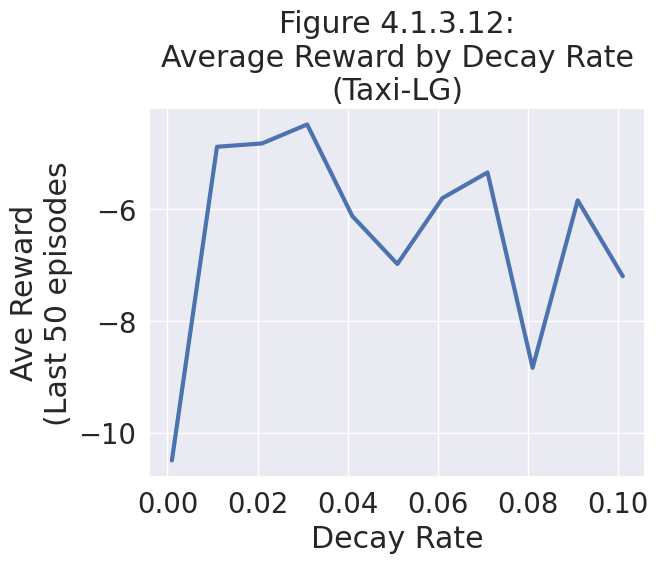

In [222]:
sns.set(font_scale=1.8)
title = "Figure 4.1.3.12:\nAverage Reward by Decay Rate\n(Taxi-LG)"

plt.plot(exploration_decay_rates, ave_rewards_edr, lw=3, label="Rewards")

plt.xlabel("Decay Rate")
plt.ylabel("Ave Reward\n(Last 50 episodes")

plt.title(title)
plt.savefig(title.replace(".","").replace("\n","")+".svg",bbox_inches="tight")

In [ ]:
sns.set(font_scale=1.8)
title = "Figure 4.1.3.10:\nDelta by Decay Rate (Taxi-LG)"

for n in [0,5,10]:
    rates = pd.DataFrame(deltas_edr[n])
    rates_sma = get_sma(rates, 50)
    st_up, st_down = get_bollinger_bands(rates,50)

    plt.plot(rates_sma)
    plt.fill_between(np.arange(train_episodes_lg), st_up[0], st_down[0], alpha=0.5,label=f'Rate: {np.round(exploration_decay_rates[n],3)}')
    
plt.legend()
plt.xlabel("Episodes")
plt.ylabel("Deltas")
plt.title(title)
plt.savefig(title.replace(".","").replace("\n","")+".svg",bbox_inches="tight")

In [200]:
env_lg.reset()
V_ql = None
times_ql = []
for _ in range(5):
    s_time = time.perf_counter()
    _, _, _, _ = q_learning(env_lg, learning_rate=0.8, discount_factor=0.99, decay=0.015, early_stopping=True,train_episodes=5000)
    times_ql.append(time.perf_counter() - s_time)

/opt/conda/lib/python3.7/site-packages/gym/utils/seeding.py:28: DeprecationWarning: WARN: Function `rng.rand(*size)` is marked as deprecated and will be removed in the future. Please use `Generator.random(size)` instead.
  linear correlations between seeds of multiple PRNG's can correlate


In [203]:
env_s.reset()

_,_,Q,_ = q_learning(env_lg, learning_rate=0.8, discount_factor=0.99, decay=0.015,train_episodes=6000)

policy_ql_lg = np.argmax(Q,axis=1)

n_episodes = 1000
wins, rewards_ql = play_episodes(env_lg, n_episodes, policy_ql_lg, random = False,rewards_aggrated=False)
print(f'Win Percentage with Q-Learning: {wins/n_episodes*100}%')
print(f"Average rewards with Q-Learning: {np.mean(rewards_ql)}")
print(f"Average times with Q-Learning: {np.mean(times_ql)}")

Win Percentage with Q-Learning: 97.2%
Average rewards with Q-Learning: -15.221
Average times with Q-Learning: 4.802589385400279


# Comparing LG policies

In [243]:
policy_vi_lg[policy_vi_lg==4].shape

(16,)

In [245]:
np.mean(policy_vi_lg[policy_vi_lg==4]==policy_ql_lg[policy_vi_lg==4])

0.75

In [208]:
policies_lg = pd.DataFrame(np.array((policy_vi_lg,policy_pi_lg,policy_ql_lg)).transpose(),columns=["VI","PI","QL"])

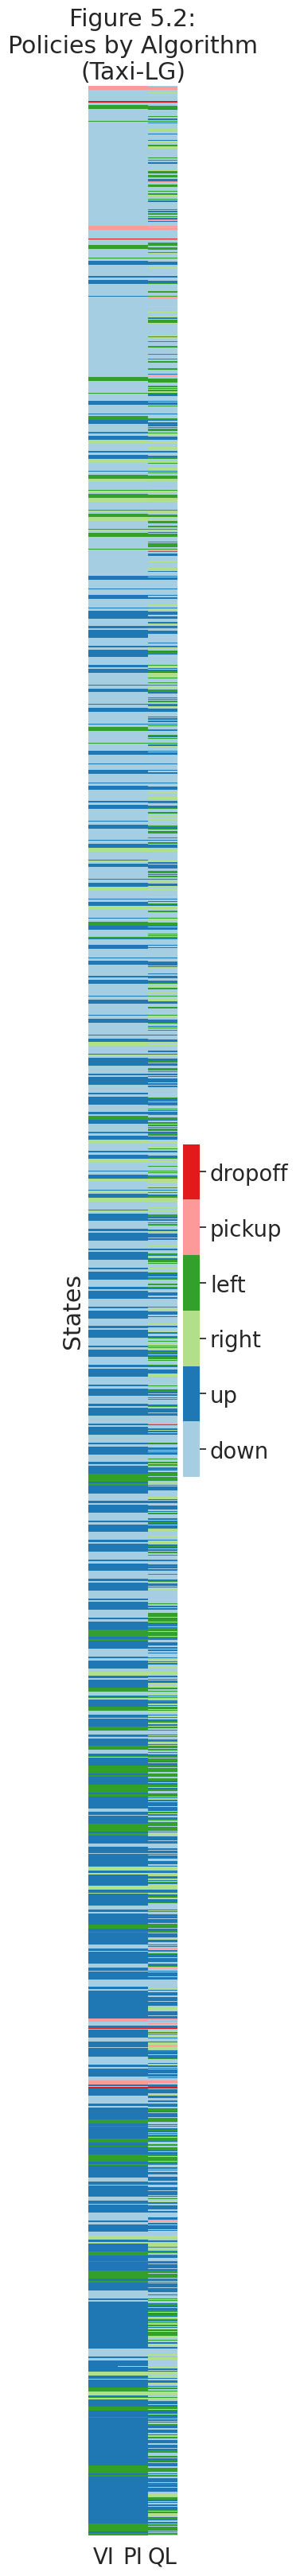

In [239]:
sns.set(font_scale=1.8)
title = "Figure 5.2:\nPolicies by Algorithm\n(Taxi-LG)"

plt.figure(figsize=(1.8,40))

cmap = sns.color_palette("Paired", 6) 
ax = sns.heatmap(policies_lg,cmap=cmap,yticklabels=False) 
# modify colorbar:
colorbar = ax.collections[0].colorbar 
r = colorbar.vmax - colorbar.vmin 
colorbar.set_ticks([colorbar.vmin + r / 6 * (0.5 + i) for i in range(6)])
colorbar.set_ticklabels(list(action_text.values())) 
plt.ylabel("States")
plt.title(title)
plt.savefig(title.replace(".","").replace("\n","")+".svg",bbox_inches="tight")

In [212]:
np.mean(policy_vi_lg==policy_pi_lg)

0.9996031746031746

In [215]:
policy_vi_lg[policy_vi_lg!=policy_pi_lg]

array([1.])

In [216]:
policy_pi_lg[policy_vi_lg!=policy_pi_lg]

array([0.])

In [217]:
np.mean(policy_vi_lg==policy_ql_lg)

0.6214285714285714